In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# neusmeren beztezinski graf
G = nx.Graph()

# KREIRANJE CVOROVA

# Ucitavanje stajalista
stopsPath = "../Desktop/asmPodaci/stops.txt"
stops = pd.read_csv(stopsPath)

for stop in stops.itertuples(index=False):
    stop_id = stop.stop_id
    stop_name = stop.stop_name
    stop_lat = stop.stop_lat
    stop_lon = stop.stop_lon
    zone_id = stop.zone_id
    G.add_node(stop_id, name=stop_name, lat=stop_lat, lon=stop_lon, zone=zone_id)
    
# KREIRANJE GRANA
    
tripStopTimesPath = "../Desktop/sredjeniPodaci/tripStopTimes.txt"
tripStopTimes = pd.read_csv(tripStopTimesPath, sep='\t')

# prethodnom analizom sam zakljucila da sve nocne linije pocinju sa 50, 51 ili 52 i posle imaju vrednost vecu od 15
# izbacujem nocne linije jer se u zadatku trazi ispitivanje za dnevni rezim
indexes = tripStopTimes[(tripStopTimes['route_id'].astype(str).str.startswith('50')) & (tripStopTimes['route_id'] >= 50015)].index
tripStopTimes.drop(indexes , inplace=True)
indexes = tripStopTimes[(tripStopTimes['route_id'].astype(str).str.startswith('51')) & (tripStopTimes['route_id'] >= 51015)].index
tripStopTimes.drop(indexes , inplace=True)
indexes = tripStopTimes[(tripStopTimes['route_id'].astype(str).str.startswith('52')) & (tripStopTimes['route_id'] >= 52015)].index
tripStopTimes.drop(indexes , inplace=True)
indexes = tripStopTimes[(tripStopTimes['route_id'].astype(str).str.startswith('53')) & (tripStopTimes['route_id'] >= 53015)].index
tripStopTimes.drop(indexes , inplace=True)

# izbacujem sva stajalista koja koriste samo nocne linije
stops = stops[stops['stop_id'].isin(tripStopTimes['stop_id'])]

# 2) Dodavanje grana između krajnje tacke jednog smera sa pocetnom tackom drugog smera
def merge_endpoints(group):
    min_stop = group[group['stop_sequence'] == group['stop_sequence'].min()]['stop_id'].values[0]
    max_stop = group[group['stop_sequence'] == group['stop_sequence'].max()]['stop_id'].values[0]
    return min_stop, max_stop

for route_id, group in tripStopTimes.groupby('route_id'):
    # neke linije nemaju dva smera
    if len(group['direction_id'].unique()) == 2:
        minMaxDirZero = merge_endpoints(group[group['direction_id'] == 0])  # pocetna i krajnja tacka prvog smera
        minMaxDirOne = merge_endpoints(group[group['direction_id'] == 1])  # pocetna i krajnja tacka drugog smera
        if(minMaxDirZero[0] != minMaxDirOne[1]):
            G.add_edge(minMaxDirZero[0], minMaxDirOne[1])
        if(minMaxDirZero[1] != minMaxDirOne[0]):
            G.add_edge(minMaxDirZero[1], minMaxDirOne[0])

# postoje stop_id koji su NaN, pa te vrednosti izbacujem, da se ne bi stvarali dodatni cvorovi
tripStopTimes = tripStopTimes.dropna(subset=['stop_id'])

# OVO IPAK NE jer je receno u zadatku da skup stajalista moze varirati u zavisnosti od polazaka linijetripStopTimes = tripStopTimes.drop_duplicates(subset=['route_id','stop_id'])
# tripStopTimes = tripStopTimes.drop_duplicates(subset=['route_id','stop_id'])

# NAPOMENA:
# primetila sam da postoje linije koje imaju isto stajliste za stop_sequence = 1 i za poslednji stop_seqence
# to je npr route_id = 700
# to u L mrezi nije problem jer se spajaju samo susedna stajalista, tj susedni stop_sequence
# medjutim, u P mrezi se javljaju self-loops jer se za jedan trip_id desi da ima dva stajalista sa istim brojem pa se oni spoje

# sortiram po trip_id i stop_sequence
tripStopTimesSorted = tripStopTimes.sort_values(by=['trip_id', 'stop_sequence'])

# grupisem
tripStopTimesGrouped = tripStopTimesSorted.groupby(['trip_id', 'route_id'])

for _, group in tripStopTimesGrouped:
    #print(group)
    stop_ids = group['stop_id'].to_numpy()
    # generisanje svih kombinacija iz grupe
    combinations_list = list(combinations(stop_ids, 2))
    # Izbacivanje kombinacija sa istim parovima
    combinations_list = [(stop_id1, stop_id2) for stop_id1, stop_id2 in combinations_list if stop_id1 != stop_id2]
    G.add_edges_from(combinations_list)


In [2]:
print("Broj čvorova (stajališta):", G.number_of_nodes())
print("Broj grana:", G.number_of_edges())

# Pronalaženje čvorova sa self loop
nodes_with_selfloops = [node for node in G.nodes if G.has_edge(node, node)]

# Ispisivanje čvorova sa self loop
print("Čvorovi sa self loop:")
for node in nodes_with_selfloops:
    print(node)

Broj čvorova (stajališta): 3130
Broj grana: 84597
Čvorovi sa self loop:


In [3]:
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

Br povezanih komponenti:  7
Velicine povezanih komp:  [3124, 1, 1, 1, 1, 1, 1]


In [5]:
# zbog uklanjanja nocnih linija javlja se da su neku cvorovi bez grana, pa ih onda uklanjam jer su bespotrebni
nodes_to_remove = [1243, 1245, 1247, 3735, 3737, 3757]
G.remove_nodes_from(nodes_to_remove)

# PROVERAVAM OPET DA LI IMA NEPOVEZANIH KOMPONENTI
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

print("Broj čvorova (stajališta):", G.number_of_nodes())
print("Broj grana:", G.number_of_edges())

Br povezanih komponenti:  1
Velicine povezanih komp:  [3124]
Broj čvorova (stajališta): 3124
Broj grana: 84597


In [6]:
numOfNodes = G.number_of_nodes()
numOfEdges = G.number_of_edges()

density = 2 * numOfEdges / (numOfNodes * (numOfNodes - 1))

print("Gustina L mreze:", density)

Gustina L mreze: 0.01734211047439119


In [7]:
averageDistance = nx.average_shortest_path_length(G)
diameter = nx.diameter(G)

print("Prosecna distanca:", averageDistance)
print("Dijametar:", diameter)

Prosecna distanca: 3.198058229738223
Dijametar: 7


In [8]:
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

# provera postojanja gigantske komp
hasGiantComponent = max(sizeOfConnectedComponents) > 1
print("Postoji gigantska komp: ", hasGiantComponent)

# izracunavanje centralizacije
max_degree = max(dict(G.degree()).values()) # sadrzi cvorove kao kljuceve i njihov stepen kao vrednost
centralization = (sum([max_degree - degree for degree in dict(G.degree()).values()])) / ((len(G) - 1) * (len(G) - 2))
print("Centralizacija:", centralization)

Br povezanih komponenti:  1
Velicine povezanih komp:  [3124]
Postoji gigantska komp:  True
Centralizacija: 0.06563298525149626


Prosečni koef klasterizacije: 0.7295185705165781
Globalni koef klasterizacije: 0.42525362771880226


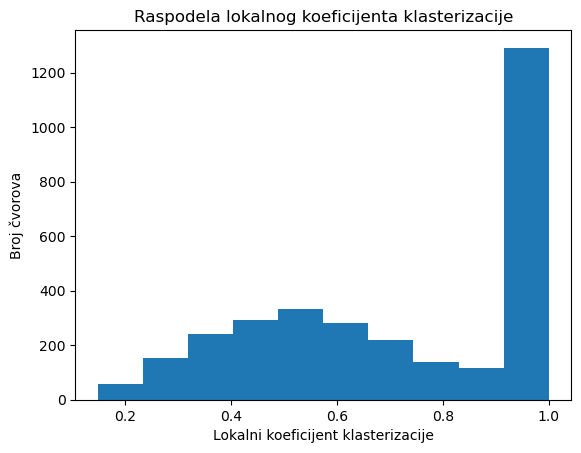

Prosečni koeficijent klasterizacije (Erdos-Renyi): 0.2000228606439173
Prosečni koeficijent klasterizacije (Scale-free): 0.011901388265273588


In [9]:
averageClusteringCoef = nx.average_clustering(G)
globalClusteringCoef = nx.transitivity(G) # compute graph transitivity, the fraction of all possible triangles present in G

print("Prosečni koef klasterizacije:", averageClusteringCoef)
print("Globalni koef klasterizacije:", globalClusteringCoef)

localClusteringCoeffs = nx.clustering(G)
plt.hist(list(localClusteringCoeffs.values()), bins=10)
plt.xlabel('Lokalni koeficijent klasterizacije')
plt.ylabel('Broj čvorova')
plt.title('Raspodela lokalnog koeficijenta klasterizacije')
plt.show()

# Generisanje Erdos-Renyi mreže
erdosRenyiGraph = nx.erdos_renyi_graph(n=len(G.nodes), p=0.2)
erdosRenyiAvgClustering = nx.average_clustering(erdosRenyiGraph)

# Generisanje scale-free mreže
scaleFreeGraph = nx.barabasi_albert_graph(n=len(G.nodes), m=2)
scaleFreeAvgClustering = nx.average_clustering(scaleFreeGraph)

print("Prosečni koeficijent klasterizacije (Erdos-Renyi):", erdosRenyiAvgClustering)
print("Prosečni koeficijent klasterizacije (Scale-free):", scaleFreeAvgClustering)

In [10]:
# izracunavanje koef asortativnosti
assortativity = nx.degree_assortativity_coefficient(G)
print("Koeficijent asortativnosti:", assortativity)

output_path = "../Desktop/asmPodaci/Pgraph.gml"

nx.write_gml(G, output_path)

Koeficijent asortativnosti: 0.09576632159097791


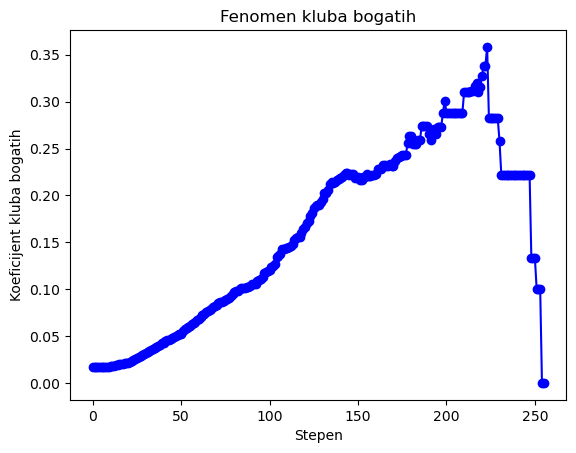

Mreža ne ispoljava rich club phenomenon.


In [11]:
richClubCoeffs = nx.rich_club_coefficient(G, normalized=False)

plt.plot(list(richClubCoeffs.keys()), list(richClubCoeffs.values()), 'bo-')
plt.xlabel('Stepen')
plt.ylabel('Koeficijent kluba bogatih')
plt.title('Fenomen kluba bogatih')
plt.show()

if max(richClubCoeffs.values()) > 1:
    print("Mreža ispoljava rich club phenomenon.")
else:
    print("Mreža ne ispoljava rich club phenomenon.")

In [12]:
# Grupisanje stajališta po tarifnim zonama
grouped_by_zone = stops.groupby('zone_id')

# Prikaz broja stajališta po zonama
print("Broj stajalista po zonama:")
print(grouped_by_zone['stop_id'].count())

Broj stajalista po zonama:
zone_id
1    1220
2    1846
3      58
Name: stop_id, dtype: int64


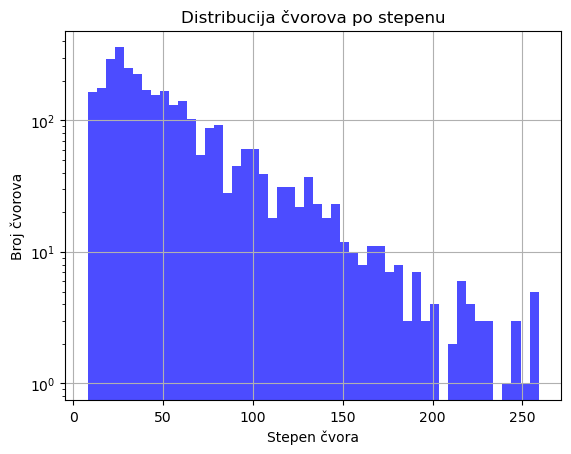

In [13]:
# Izračunavanje distribucije čvorova po stepenu
degree_distribution = dict(G.degree())

# Izračunavanje histograma distribucije čvorova po stepenu
degree_values = list(degree_distribution.values())
plt.hist(degree_values, bins=50, log=True, color='b', alpha=0.7)

# Podešavanje grafičkih elemenata
plt.xlabel('Stepen čvora')
plt.ylabel('Broj čvorova')
plt.title('Distribucija čvorova po stepenu')
plt.grid(True)

# Prikazivanje histograma
plt.show()

In [14]:
# Analiza centralnosti po stepenu
degree_centrality = nx.degree_centrality(G)

# centralnost po bliskosti
closeness_centrality = nx.closeness_centrality(G)

# relacionа centralnost
betweenness_centrality = nx.betweenness_centrality(G)

# Centralnost po stepenu sortirano
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po centralnosti po stepenu:")
print(sorted_degree_centrality[:10])

# Centralnost po bliskosti sortirano
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po centralnosti po bliskosti:")
print(sorted_closeness_centrality[:10])

# Relaciona centralnost sortirano
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po relacionoj centralnosti:")
print(sorted_betweenness_centrality[:10])  # Prikaz prvih 10 najvažnijih aktera

Najvažniji akteri po centralnosti po stepenu:
[(373, 0.0829330771693884), (148, 0.08197246237592058), (149, 0.0813320525136087), (372, 0.0813320525136087), (374, 0.0813320525136087), (503, 0.08037143772014088), (147, 0.07941082292667306), (404, 0.07941082292667306), (495, 0.07941082292667306), (496, 0.07684918347742555)]
Najvažniji akteri po centralnosti po bliskosti:
[(182, 0.4270477232325995), (184, 0.4270477232325995), (186, 0.4270477232325995), (2129, 0.42512932208004356), (790, 0.42409016838674635), (792, 0.42409016838674635), (372, 0.42168512017283283), (374, 0.42168512017283283), (188, 0.4180163298085932), (181, 0.4176250334313988)]
Najvažniji akteri po relacionoj centralnosti:
[(906, 0.05415600326129676), (495, 0.027750750779291747), (856, 0.024257539492962433), (910, 0.01989172142603876), (148, 0.019366171662221023), (221, 0.01708410306101382), (217, 0.01670900350774044), (219, 0.01670900350774044), (104, 0.016233233017946228), (291, 0.01525838800699728)]


In [15]:
# Računanje vrednosti centralnosti po sopstvenom vektoru
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sortiranje
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Prikazivanje najvažnijih čvorova
print("Najvažniji čvorovi po centralnosti po sopstvenom vektoru:")
print(sorted_eigenvector_centrality[:10])

Najvažniji čvorovi po centralnosti po sopstvenom vektoru:
[(373, 0.08086513646230024), (372, 0.07786457630005214), (374, 0.07786457630005214), (371, 0.07460406402004974), (790, 0.07346769593892652), (792, 0.07346769593892652), (793, 0.07306691823316032), (795, 0.07306691823316032), (404, 0.07266342875510802), (401, 0.07250309852856847)]


In [16]:
weight_degree = 1
weight_closeness = 0.5
weight_betweenness = 0.8
weight_eigenvector = 0.3

# Izračunavanje kompozitne mere centralnosti za svaki čvor
composite_centrality = {}
for node in G.nodes():
    composite_centrality[node] = (
        weight_degree * degree_centrality[node] +
        weight_closeness * closeness_centrality[node] +
        weight_betweenness * betweenness_centrality[node] +
        weight_eigenvector * eigenvector_centrality[node]
    )

# Sortiranje čvorova
sorted_composite_centrality = sorted(composite_centrality.items(), key=lambda x: x[1], reverse=True)

# Prikazivanje najvažnijih čvorova
print("Najvažniji čvorovi prema kompozitnoj meri centralnosti:")
print(sorted_composite_centrality[:10])

Najvažniji čvorovi prema kompozitnoj meri centralnosti:
[(372, 0.3258483191836897), (374, 0.3258483191836897), (373, 0.32207088376255066), (148, 0.31757874712174994), (503, 0.31710382078569577), (404, 0.3163323096070915), (495, 0.315420210244794), (790, 0.31085198509876827), (792, 0.31085198509876827), (149, 0.3105787938254299)]


In [17]:
import numpy as np
import networkx as nx

# fja za izracunavanje udaljenosti između geografskih koordinata
def geographic_distance(lat1, lon1, lat2, lon2):
    return ((lat1 - lat2)**2 + (lon1 - lon2)**2)**0.5

# fja za izracunavanje slicnosti stepena cvora (npr. Jaccardova sličnost)
def degree_similarity(graph, node1, node2):
    neighbors1 = set(graph.neighbors(node1))  # Skupovi svih suseda čvora
    neighbors2 = set(graph.neighbors(node2))
    intersection = neighbors1.intersection(neighbors2)  # Zajednički susedi ta dva čvora
    if len(neighbors1) == 0 or len(neighbors2) == 0:
        return 0
    return len(intersection) / min(len(neighbors1), len(neighbors2))  # Similarity overlap

# Funkcija za izračunavanje kombinovane sličnosti
def combined_similarity(graph, node1, node2, alpha=0.2):
    lat1, lon1 = graph.nodes[node1]['lat'], graph.nodes[node1]['lon']
    lat2, lon2 = graph.nodes[node2]['lat'], graph.nodes[node2]['lon']
    
    geo_dist = geographic_distance(lat1, lon1, lat2, lon2)
    deg_sim = degree_similarity(graph, node1, node2)
    
    combined_sim = alpha * geo_dist + (1 - alpha) * deg_sim
    return combined_sim

# Izračunavanje matrice sličnosti
num_nodes = len(G.nodes)
similarity_matrix = np.zeros((num_nodes, num_nodes))
node_pair_matrix = [[None] * num_nodes for _ in range(num_nodes)]

# Prolazimo kroz sve parove čvorova i računamo sličnost samo jednom za svaki par
for i, node1 in enumerate(G.nodes):
    for j, node2 in enumerate(G.nodes):
        if i < j:
            similarity = combined_similarity(G, node1, node2)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Simetrična matrica
            node_pair_matrix[i][j] = (node1, node2)
            node_pair_matrix[j][i] = (node1, node2)

# Prikaz matrice sličnosti
print(similarity_matrix)

[[0.00000000e+00 4.32348168e-04 7.86563225e-01 ... 4.28087477e-02
  4.22962100e-02 4.23618800e-02]
 [4.32348168e-04 0.00000000e+00 1.38801527e-02 ... 4.26747853e-02
  4.21639010e-02 4.22285503e-02]
 [7.86563225e-01 1.38801527e-02 0.00000000e+00 ... 4.27352827e-02
  4.22241430e-02 4.22889485e-02]
 ...
 [4.28087477e-02 4.26747853e-02 4.27352827e-02 ... 0.00000000e+00
  7.79486825e-01 7.79398691e-01]
 [4.22962100e-02 4.21639010e-02 4.22241430e-02 ... 7.79486825e-01
  0.00000000e+00 7.79070810e-01]
 [4.23618800e-02 4.22285503e-02 4.22889485e-02 ... 7.79398691e-01
  7.79070810e-01 0.00000000e+00]]


In [18]:
similarity_matrixDF = pd.DataFrame(similarity_matrix)
similarity_matrixDF.to_csv("similarity_matrixP.txt", sep='\t')
node_pair_matrixDF = pd.DataFrame(node_pair_matrix)
node_pair_matrixDF.to_csv("node_pair_matrixP.txt", sep='\t')

In [19]:
# Generisanje Laplasijan matrice
laplacian_matrix = nx.laplacian_matrix(G)
print(laplacian_matrix)
L_array = nx.laplacian_matrix(G).toarray()
print(L_array)
laplacian_matrixDF = pd.DataFrame(laplacian_matrix)
laplacian_matrixDF.to_csv("laplacian_matrixL.txt", sep='\t')

# Pretvaranje Laplasijan matrice u graf Laplasijane
#L_graph = nx.from_scipy_sparse_array(L)
#print(L_graph)
# Iscrtajte graf Laplasijane
#nx.draw(L_graph, with_labels=True, node_color='lightblue', font_weight='bold')
#plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 50:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


  (0, 0)	59
  (0, 1)	-1
  (0, 2)	-1
  (0, 4)	-1
  (0, 6)	-1
  (0, 8)	-1
  (0, 10)	-1
  (0, 12)	-1
  (0, 14)	-1
  (0, 16)	-1
  (0, 18)	-1
  (0, 20)	-1
  (0, 22)	-1
  (0, 24)	-1
  (0, 26)	-1
  (0, 28)	-1
  (0, 30)	-1
  (0, 31)	-1
  (0, 33)	-1
  (0, 41)	-1
  (0, 43)	-1
  (0, 57)	-1
  (0, 59)	-1
  (0, 62)	-1
  (0, 64)	-1
  :	:
  (3123, 2836)	-1
  (3123, 2838)	-1
  (3123, 2840)	-1
  (3123, 2842)	-1
  (3123, 2844)	-1
  (3123, 2846)	-1
  (3123, 2848)	-1
  (3123, 2850)	-1
  (3123, 2876)	-1
  (3123, 2878)	-1
  (3123, 2880)	-1
  (3123, 2881)	-1
  (3123, 3021)	-1
  (3123, 3022)	-1
  (3123, 3113)	-1
  (3123, 3114)	-1
  (3123, 3115)	-1
  (3123, 3116)	-1
  (3123, 3117)	-1
  (3123, 3118)	-1
  (3123, 3119)	-1
  (3123, 3120)	-1
  (3123, 3121)	-1
  (3123, 3122)	-1
  (3123, 3123)	38
[[59 -1 -1 ...  0  0  0]
 [-1 58  0 ...  0  0  0]
 [-1  0 58 ...  0  0  0]
 ...
 [ 0  0  0 ... 38 -1 -1]
 [ 0  0  0 ... -1 38 -1]
 [ 0  0  0 ... -1 -1 38]]


In [20]:
from scipy.linalg import eigh

eigenvalues, eigenvectors = np.linalg.eig(L_array)
#eigenvalues, eigenvectors = eigh(L_array)

In [43]:
sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Prikaz rezultata
print("Sopstvene vrednosti:")
print(eigenvalues)
print("\nSopstveni vektori:")
print(eigenvectors)

Sopstvene vrednosti:
[1.13686838e-13+0.j 7.46965257e-01+0.j 8.91455775e-01+0.j ...
 2.57003094e+02+0.j 2.58678528e+02+0.j 2.61668910e+02+0.j]

Sopstveni vektori:
[[-1.78914067e-02+0.j -1.15059958e-03+0.j -4.02259634e-03+0.j ...
   1.84965580e-04+0.j  2.23284387e-03+0.j -8.89068142e-05+0.j]
 [-1.78914067e-02+0.j -1.16153232e-03+0.j -3.96030334e-03+0.j ...
  -2.39205202e-04+0.j -4.42975708e-03+0.j  6.97944670e-05+0.j]
 [-1.78914067e-02+0.j -1.15078409e-03+0.j -4.02154246e-03+0.j ...
   1.87118697e-04+0.j  2.26637845e-03+0.j -8.96937540e-05+0.j]
 ...
 [-1.78914067e-02+0.j -1.74698044e-03+0.j -6.67124488e-03+0.j ...
  -5.48567407e-07+0.j -2.52719201e-06+0.j  5.71157198e-07+0.j]
 [-1.78914067e-02+0.j -1.74698044e-03+0.j -6.67124488e-03+0.j ...
  -5.48567407e-07+0.j -2.52719201e-06+0.j  5.71157198e-07+0.j]
 [-1.78914067e-02+0.j -1.74698044e-03+0.j -6.67124488e-03+0.j ...
  -5.48567407e-07+0.j -2.52719201e-06+0.j  5.71157198e-07+0.j]]


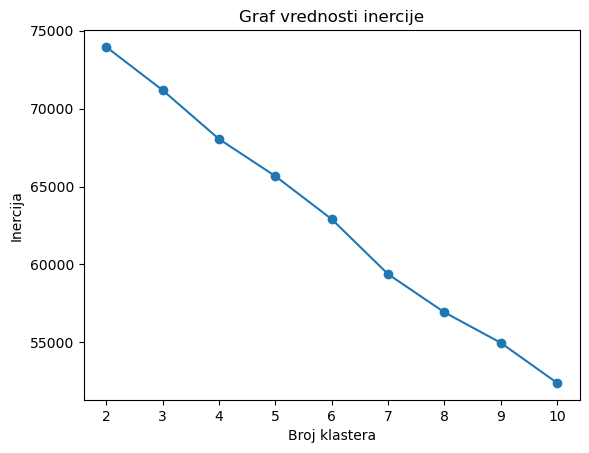

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Pravim praznu listu za vrednosti inercije
inertia_values = []

# Pokušavam različite brojeve klastera od 2 do 10
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(similarity_matrix)
    inertia_values.append(kmeans.inertia_)

# Prikazujem graf vrednosti inercije u zavisnosti od broja klastera
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title('Graf vrednosti inercije')
plt.xlabel('Broj klastera')
plt.ylabel('Inercija')
plt.show()


In [22]:
from sklearn.cluster import SpectralClustering

# Spektralno klasterisanje
spectral_clustering = SpectralClustering(n_clusters=7, affinity='precomputed_nearest_neighbors')
cluster_labels = spectral_clustering.fit_predict(similarity_matrix)

# Rezultati klasterisanja
print("Rezultati klasterisanja:")
print(cluster_labels)
print(len(cluster_labels))

file_name = "rezultati_klasterisanja.txt"

with open(file_name, "w") as file:
    for label in cluster_labels:
        file.write(f"{label}\n")

Rezultati klasterisanja:
[2 2 2 ... 4 4 4]
3124


In [26]:
import folium
import pandas as pd

stopsPath = "../Desktop/asmPodaci/stops.txt"
data = pd.read_csv(stopsPath)
stop_ids_to_remove = [1243, 1245, 1247, 3735, 3737, 3757]
data = data[~data['stop_id'].isin(stop_ids_to_remove)]
data['cluster_label'] = cluster_labels
#print(data)

m = folium.Map(location=[data['stop_lat'].mean(), data['stop_lon'].mean()], zoom_start=13)

cluster_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4']

for index, row in data.iterrows():
    label = row['cluster_label']
    color = cluster_colors[label]
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=row['stop_name']
    ).add_to(m)

m.save("Pmreza_mapa.html")
